Changes from v2:

1. ATR is calculated inside strategy s.t. it can be used to calculate take profit and stop loss
2. implemented PCA to reduce dimension

## Import Library

In [ ]:
from humpback import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import ta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

from backtesting import Backtest, Strategy

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Defining Functions

Functions in this section would be moved to humpback.py after testing for tidiness

https://keras.io/examples/timeseries/timeseries_traffic_forecasting/

## Defining Model

In [24]:
class MyModel:
    def __init__(self):
        self.optimizer = 'adam'
        self.loss      = 'mean_squared_error'

    def trainModel(self, data_X, data_y, epochs: int = 20, batch_size: int = 32) -> None:
        self.trainScaler_X(data_X)
        self.trainScaler_y(data_y)

        self.trainPCA(data_X)
        eigen_X = self.pca.transform(self.scaler_X.transform(data_X))

        self.model = Sequential()
        self.model.add(LSTM(units=50,
                            return_sequences=True,
                            input_shape=(data_X.shape[1],1)))
        self.model.add(Dropout(0.2))

        self.model.add(LSTM(units=50,
                            return_sequences=True))
        self.model.add(Dropout(0.2))

        self.model.add(LSTM(units=50,
                            return_sequences=True))
        self.model.add(Dropout(0.2))

        self.model.add(LSTM(units=50))
        self.model.add(Dropout(0.2))

        self.model.add(Dense(units=1))

        self.model.compile(optimizer=self.optimizer,
                           loss=self.loss)

        self.model.fit(eigen_X,
                       self.scaler_y.transform(data_y),
                       epochs=epochs,
                       batch_size=batch_size)
    
    def trainScaler_X(self, data_X) -> None:
        self.scaler_X = MinMaxScaler()
        self.scaler_X.fit(data_X)

    def trainScaler_y(self, data_y) -> None:
        self.scaler_y = MinMaxScaler()
        self.scaler_y.fit(data_y)

    def predictModel(self, data_X):
        """output a predicted y given X

        Args:
            data_X (DataFrame): a pd.DataFrame of single row. Unscaled.

        Returns:
            unscaled prediction
        """
        scaled_X = self.scaler_X.transform(data_X)
        eigen_X = self.pca.transform(scaled_X)
        predict = self.model.predict(eigen_X)
        result = pd.DataFrame(self.scaler_y.inverse_transform(predict),
                              index=data_X.index)
        return result
    
    def trainPCA(self, data_X) -> None:
        self.pca = PCA(n_components=3)
        self.pca.fit(data_X)

    def get_model(self):
        return self.model

## Defining Strategy

In [ ]:
class MyStr(Strategy):
    # Variables:
    # train_size = 0.7
    buy_threshold  =  .005
    sell_threshold = -.005

    # hardcoded 10000 training size
    N_train = 3500

    def init(self):
        # Declare indicators you will use in the strategy:
        self.getData()
        self.model_init()

    def next(self):
        if len(self.data) < self.N_train:
            return


        X = featureGeneration(self.data.df.iloc[-120:])
        X, _ = getXy(X, 'Return')
        forecast = self.model.predictModel(X.iloc[[-1]])[0]
        
        atr_tp_sl = atr(self.data.df)

        if forecast > self.buy_threshold and not self.position.is_long:
            tp = self.data.Close[-1] + 2 * atr_tp_sl[-1]
            sl = self.data.Close[-1] - 2 * atr_tp_sl[-1]
            self.buy(size=.2, tp=tp, sl=sl)

        if forecast < self.sell_threshold and not self.position.is_short:
            tp = self.data.Close[-1] - 2 * atr_tp_sl[-1]
            sl = self.data.Close[-1] + 2 * atr_tp_sl[-1]
            self.sell(size=.2, tp=tp, sl=sl)

########################################

    def getData(self):
        data_train = getReturn(self.data.df)
        data_train = featureGeneration(data_train)
        self.X_train, self.y_train = getXy(data_train.iloc[:-self.N_train,])

    def model_init(self):
        self.model = MyModel()
        self.model.trainModel(self.X_train, self.y_train, epochs=4)

    def get_model(self):
        return self.model.get_model()


In [ ]:
class WalkForwardStr(MyStr):
    def next(self):
        # Skip the cold start period with too few values available
        if len(self.data) < len(self.y_train):
            return
            
        if len(self.data) % 500:
            return super().next()

        # Retrain on last N_TRAIN values
        self.getData()
        self.model_init()

        # Now that the model is fitted, 
        # proceed the same as in MLTrainOnceStrategy
        super().next()

## Parameters

This section contains all the parameters.

In [ ]:
# # This chunk specifies the data

# symbol = 'BTCUSDT'
# interval = '1h'

# start_str = int(datetime(2020,1,1,0,0).timestamp() * 1000)
# end_str    = int(datetime(2023,12,31,0,0).timestamp() * 1000)

## Obtain data

This section outputs training and testing data for the use of the following sections.

In [ ]:
# client = connectBinanceAPI()

In [ ]:
# data_raw = getBinanceData(client=client,
#                           symbol=symbol,
#                           interval=interval,
#                           start_str=start_str,
#                           end_str=end_str)

## Backtesting

In [ ]:
# bt    = Backtest(data_raw, WalkForwardStr, cash = 1000000, commission=0.00075, margin=.05)
# stats = bt.run()

## Results

In [ ]:
# bt.plot()

In [ ]:
# stats.tail()

In [ ]:
# stats['_equity_curve']

## Ad hoc

In [ ]:
# # This chunk specifies the data

# symbol = 'BTCUSDT'
# interval = '1h'

# start_str = int(datetime(2020,1,1,0,0).timestamp() * 1000)
# end_str    = int(datetime(2023,12,31,0,0).timestamp() * 1000)

In [ ]:
# client = connectBinanceAPI()

In [ ]:
# data_raw = getBinanceData(client=client,
                        #   symbol=symbol,
                        #   interval=interval,
                        #   start_str=start_str,
                        #   end_str=end_str)

In [ ]:
data_train, data_test = train_test_split(data_raw,
                                         train_size=0.7,
                                         shuffle=False)
data_train, data_test = [getReturn(data, 'Close') for data in [data_train, data_test]]
data_train, data_test = [featureGeneration(data)  for data in [data_train, data_test]]
X_train, y_train = getXy(data_train, 'Return')
X_test , y_test  = getXy(data_test , 'Return')

In [28]:
myModel = MyModel()
myModel.trainModel(X_train, y_train, epochs=5)

Epoch 1/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0162
Epoch 2/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0017
Epoch 3/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0013
Epoch 4/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0011
Epoch 5/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 8.1323e-04
Epoch 6/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 6.8129e-04
Epoch 7/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 6.3414e-04
Epoch 8/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 5.6899e-04
Epoch 9/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 5.5302e-04
Epoch 10/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 5.4046e-04
Epoch 11/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 5.6115e-04
Epoch 12/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 5.2106e-04
Epoch 13/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 5.2702e-04
Epoch 14/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 5.4572e-04
Epoch 15/20
764/

In [29]:
predict = myModel.predictModel(X_test)

326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


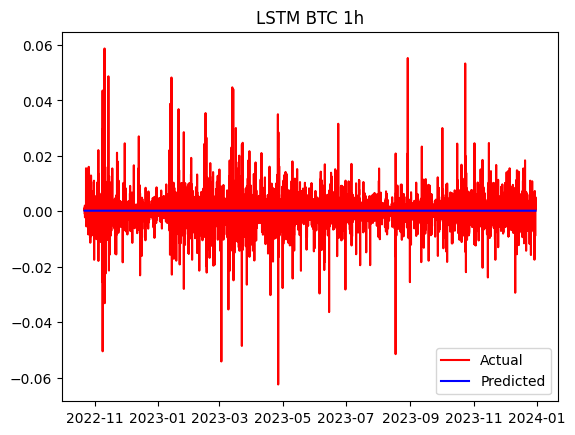

In [31]:
plt.plot(y_test, color='red', label='Actual')
plt.plot(predict, color='blue', label='Predicted')
plt.title('LSTM BTC 1h')
plt.legend() 